# The Quantum Phase Estimation Algorithm

In this tutorial, you will run the Quantum Phase Estimation algorithm using the Sampler primitive Qiskit Runtime program.

TODO
Add context of why QPE is important and why Sampler is advantagous to conventional backend.run() method for running QPE.

## Set up your local development environment

This tutorial requires a Qiskit Runtime service instance. If you haven't done so already, please follow the [Getting Started Guide](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/getting_started.html) to set one up.

## Background information

### Quantum phase estimation

TODO: Improve explanations. Why is QPE important?

Quantum phase estimation is one of the most important subroutines in quantum computation. It serves as a central building block for many quantum algorithms. The objective of the algorithm is the following:

Given a unitary operator $U$, the algorithm estimates $\theta$ in $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$. Here $|\psi\rangle$ is an eigenvector and $e^{\boldsymbol{2\pi i}\theta}$ is the corresponding eigenvalue. Since $U$ is unitary, all of its eigenvalues have a norm of 1.

If you want to learn more, you can read the chapter about quantum phase estimation in [the Qiskit textbook](https://learn.qiskit.org/course/ch-algorithms/quantum-phase-estimation).

## Step 1: Create QPE circuits and bind parameters to the circuits

### Create QPE circuits

TODO: Add descriptions of what is happening here.

In [1]:
import numpy as np

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library import QFT

def create_qpe_circuit(phase, num_qubits):
    # Create circuit
    aux = QuantumRegister(size=num_qubits, name='aux')  # auxillary register for reading out the phase
    phi = QuantumRegister(size=1, name='phi')  # register with eigenvector |phi>
    cr = ClassicalRegister(size=num_qubits, name='readout')
    qpe = QuantumCircuit(aux, phi, cr)

    # Prepare |phi>
    qpe.x(phi)

    # Create superposition in aux register
    qpe.barrier()
    qpe.h(aux)  

    # Apply C-U black box
    qpe.barrier()
    for j in range(num_qubits):
        qpe.cp(phase*(2**j), j, num_qubits)

    # Apply inverse QFT
    qpe.barrier()
    qpe.compose(QFT(num_qubits, inverse=True), inplace=True)

    # Measure
    qpe.barrier()
    qpe.measure(aux, cr)

    return qpe

### Bind parameters to QPE circuits

TODO: add description of what is happening here. Highlight why Sampler primitive is better than backend.run

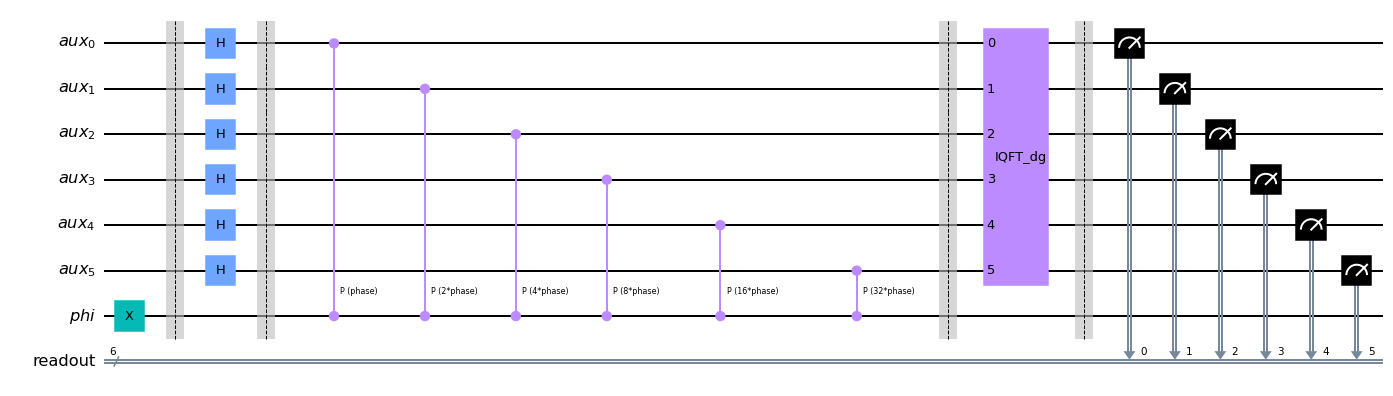

In [2]:
from qiskit.circuit import Parameter

phase = Parameter('phase')
qpe_circuit = create_qpe_circuit(phase, 6)
qpe_circuit.draw(fold=False)

In [3]:
number_of_phases = 81
phases = np.linspace(0, 4*np.pi, number_of_phases)
# Phases need to be expressed as list of lists
individual_phases = [[ph] for ph in phases]

## Step 2: Submit the circuits to a quantum computer on the cloud

### Connect to the Qiskit Runtime service 

First, connect to the Qiskit Runtime service instance that you created in [the first step](#Set-up-your-local-development-environment).

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
options = {'backend_name': 'ibmq_qasm_simulator'}  # use the simulator

### Run the circuits using the Sampler primitive

TODO: add description

In [5]:
from qiskit_ibm_runtime import Sampler

with Sampler(circuits=qpe_circuit, service=service, options=options) as sampler:
    param_results = sampler(circuits=[0]*len(phases), parameter_values=individual_phases)

## Step 3: Analyze results

TODO
- Remove these helper functions or move them under the cover
- Add descriptions

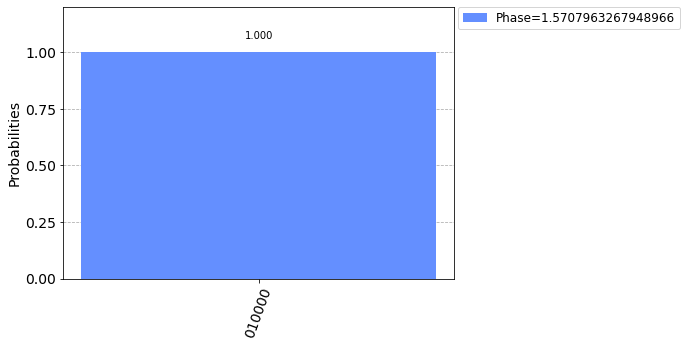

In [6]:
from qiskit.tools.visualization import plot_histogram

# idx / 80 * 4 * pi = idx / 20 * pi
idx = 10
plot_histogram(param_results.quasi_dists[idx], legend=['Phase='+str(phases[idx])])

In [7]:
def most_likely_bitstring(result_dict):
    return max(result_dict, key=result_dict.get)

def find_neighbours(most_likely_key):

    if most_likely_key == len(most_likely_key)*'0':
        neighbor_left = len(most_likely_key)*'1'
    else:
        neighbor_left = format((int(most_likely_key,2)-1), '0%sb'%len(most_likely_key))

    if most_likely_key == len(most_likely_key)*'1':
        neighbor_right = len(most_likely_key)*'0'
    else:
        neighbor_right = format((int(most_likely_key,2)+1), '0%sb'%len(most_likely_key))

    return (neighbor_left, neighbor_right)

def estimate_phase(result_dict):
    num_1_key = most_likely_bitstring(result_dict)
    neighbor_left, neighbor_right = find_neighbours(num_1_key)

    num_1_prob = result_dict.get(num_1_key)
    neighbor_left_prob = result_dict.get(neighbor_left)
    neighbor_right_prob = result_dict.get(neighbor_right)

    if neighbor_left_prob is None:
        # neighbor_left doesn't exist
        if neighbor_right_prob is None:
            # both neighbors don't exist, num_2 is num_1
            num_2_key = num_1_key
            num_2_prob = num_1_prob
        else:
            # only neighbor_left doesn't exist, num_2 is neighbor_right
            num_2_key = neighbor_right
            num_2_prob = neighbor_right_prob
    elif neighbor_right_prob is None:
        # only neighbor_right doesn't exist, num_2 is neighbor_left
        num_2_key = neighbor_left
        num_2_prob = neighbor_left_prob
    elif neighbor_left_prob > neighbor_right_prob:
        # both neighbours exist, num_2 is neighor_left because it has higher probability
        num_2_key = neighbor_left
        num_2_prob = neighbor_left_prob        
    else:
        # both neighbours exist, num_2 is neighor_right because it has higher probability
        num_2_key = neighbor_right
        num_2_prob = neighbor_right_prob

    num_1_phase = (int(num_1_key, 2) / 2**6) * 2 * np.pi
    num_2_phase = (int(num_2_key, 2) / 2**6) * 2 * np.pi

    phase_estimated = (num_1_phase * num_1_prob + num_2_phase * num_2_prob) / (num_1_prob + num_2_prob)

    return phase_estimated

print(estimate_phase(param_results.quasi_dists[idx]))
print(phases[idx])

1.5707963267948966
1.5707963267948966


In [8]:
qpe_solution = []
for idx, results in enumerate(param_results.quasi_dists):
    qpe_solution.append(estimate_phase(results))


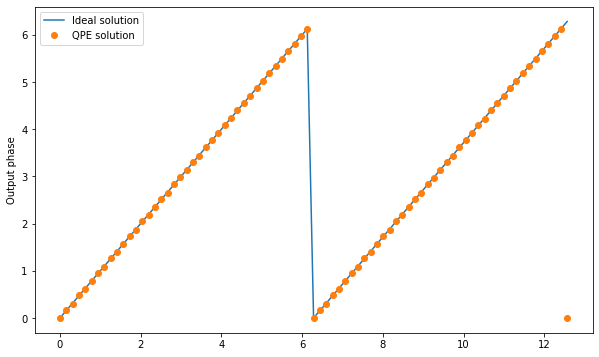

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
ideal_solution = np.append(phases[:40], np.subtract(phases[40:], 2*np.pi))
plt.plot(phases, ideal_solution, label='Ideal solution')
plt.plot(phases, qpe_solution, 'o', label='QPE solution')

plt.ylabel('Output phase')
plt.legend()

TODO:
- Add summary
- Add qiskit-ibm-runtime version
- Add qiskit version table
- Add qiskit copyright